In [130]:
# Imports
import pandas as pd
from typing import Dict
import seaborn as sns

In [131]:
# File paths
NEW_BUILD_CSV: str = "Data/Neubauwohnungen_Zürich.csv"
TAXABLE_INCOME_CSV: str = "Data/Vermögen_Stadt_zürich.csv"
EQUIVALIZED_INCOME_CSV: str = "Data/Haushaltsäquivalenz-Einkommen.csv"

In [132]:
NEW_BUILD_COLMAP: Dict[str, str] = {
    # grouping
    "KreisLang": "district_name",
    "QuarLang": "quarter_name",
    "FuenfjahresPeriode_noDM": "five_year_period",
    # metrics
    "AnzRentner": "num_retirees",
    "AnzKinder": "num_children",
    "Wohnflaeche": "living_area",
    "AnzZimmerLevel2Cd_noDM": "num_rooms",
    "AnzWhgStat": "num_appartments",
    "AnzBestWir": "population_total",
    "MietwohnungSort": "num_rental_apartment",  
}

TAXABLE_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "SteuerEinkommen_p50": "taxable_income_p50",  # median taxable income (per year)
}

EQUIVALIZED_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "aequEK_p50": "equivalized_income_p50",  # median equivalized income (per year)
}

In [133]:
def load_and_rename(csv_path: str, colmap: Dict[str, str]) -> pd.DataFrame:
    """Rename the CSV files"""
    df = pd.read_csv(csv_path)
    return df.rename(columns=colmap)

In [134]:
def aggregate_new_build_by_district(csv_path: str = NEW_BUILD_CSV) -> pd.DataFrame:
    """
    Aggregate new-build apartments by district and five-year period.
    Logic matches the original:
      - sums of retirees, children, living area, rooms, appartements, population, rental_appartments
    """
    df = load_and_rename(csv_path, NEW_BUILD_COLMAP)

    aggregated = (
        df.groupby(["district_name", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_dwellings=("num_appartments", "sum"),
              population_total=("population_total", "sum"),
              rental_dwellings=("num_rental_apartment", lambda x: (x == 1).sum()),
          )
          .reset_index()
    )

    return aggregated

In [135]:
def aggregate_new_build_by_quarter(csv_path: str = NEW_BUILD_CSV) -> pd.DataFrame:
    """
    Aggregate new-build apartments by quarter and five-year period.
    Same metrics and logic as the district-level aggregation.
    """
    df = load_and_rename(csv_path, NEW_BUILD_COLMAP)

    aggregated = (
        df.groupby(["quarter_name", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_dwellings=("num_appartments", "sum"),
              population_total=("population_total", "sum"),
              rental_dwellings=("num_rental_apartment", lambda s: (s == 1).sum()),
          )
          .reset_index()
    )

    return aggregated

In [136]:
def aggregate_taxable_income_by_district(
    csv_path: str = TAXABLE_INCOME_CSV,
    year_min_inclusive: int = 2015,
    year_max_exclusive: int = 2019,
) -> pd.DataFrame:
    """
    Filter to years >= 2015, then group by district and compute the mean of the
    annual median taxable incomes (p50). Matches the original logic exactly.
    """
    df = load_and_rename(csv_path, TAXABLE_INCOME_COLMAP)
    df = df[(df["year"] >= year_min_inclusive) & (df["year"] < year_max_exclusive)]

    aggregated = (
        df.groupby("district_name")
          .agg(median_taxable_income=("taxable_income_p50", "mean"))
          .reset_index()
    )
    return aggregated

In [137]:
def aggregate_equivalized_income_by_district(
    csv_path: str = EQUIVALIZED_INCOME_CSV,
    year_min_inclusive: int = 2015,
    year_max_exclusive: int = 2019,
) -> pd.DataFrame:
    """
    Filter to 2015 <= year < 2019, then group by district and compute the mean
    of the annual median equivalized incomes (p50). Matches original logic.
    """
    df = load_and_rename(csv_path, EQUIVALIZED_INCOME_COLMAP)
    df = df[(df["year"] >= year_min_inclusive) & (df["year"] < year_max_exclusive)]

    aggregated = (
        df.groupby("district_name")
          .agg(median_equivalized_income=("equivalized_income_p50", "mean"))
          .reset_index()
    )
    return aggregated

In [138]:
def build_join_df(
    taxable_income_by_district: pd.DataFrame,
    new_build_by_district: pd.DataFrame,
    equivalized_income_by_district: pd.DataFrame,
) -> pd.DataFrame:
    """
    Reproduce the two-step LEFT/RIGHT merge from the original code:
      1) LEFT join taxable_income_by_district with new_build_by_district on district
      2) RIGHT join result with equivalized_income_by_district on district
    The final 'right' join ensures all districts from the taxable/new_build join
    are kept (as per original).
    """
    join_left = pd.merge(
        taxable_income_by_district,
        new_build_by_district,
        on="district_name",
        how="left",
    )

    joined = pd.merge(
        equivalized_income_by_district,
        join_left,
        on="district_name",
        how="right",
    )
    return joined


In [139]:
# New-build aggregations (district & quarter)
new_build_by_quarter = aggregate_new_build_by_quarter()
new_build_by_district = aggregate_new_build_by_district()

# Income aggregations
taxable_income_by_district = aggregate_taxable_income_by_district()
equivalized_income_by_district = aggregate_equivalized_income_by_district()

# Final join
joined_df = build_join_df(
    taxable_income_by_district=taxable_income_by_district,
    new_build_by_district=new_build_by_district,
    equivalized_income_by_district=equivalized_income_by_district,
)

# View results
(new_build_by_quarter)
(taxable_income_by_district)
(equivalized_income_by_district)
(joined_df)

,district_name,median_equivalized_income,median_taxable_income,five_year_period,num_retirees,num_children,living_area,num_rooms,num_dwellings,population_total,rental_dwellings
0,Kreis 1,65.257037,77.108333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kreis 10,56.927500,64.533333,2015–2019,138.0,521.0,81799.0,527.0,878.0,2051.0,120.0
2,Kreis 10,56.927500,64.533333,2020–2024,53.0,207.0,39621.0,425.0,446.0,963.0,88.0
3,Kreis 11,50.025250,52.108333,2015–2019,282.0,645.0,152628.0,1127.0,1694.0,3545.0,250.0
4,Kreis 11,50.025250,52.108333,2020–2024,309.0,989.0,193924.0,974.0,2389.0,5056.0,247.0
5,Kreis 12,39.501111,41.454167,2015–2019,402.0,1003.0,157775.0,516.0,1779.0,4327.0,154.0
6,Kreis 12,39.501111,41.454167,2020–2024,216.0,197.0,45411.0,402.0,582.0,1145.0,107.0
7,Kreis 2,58.973500,64.537500,2015–2019,218.0,921.0,133098.0,714.0,1412.0,3506.0,163.0
8,Kreis 2,58.973500,64.537500,2020–2024,178.0,824.0,137466.0,645.0,1623.0,3631.0,165.0
9,Kreis 3,51.827000,54.562500,2015–2019,192.0,425.0,62254.0,499.0,740.0,1722.0,129.0


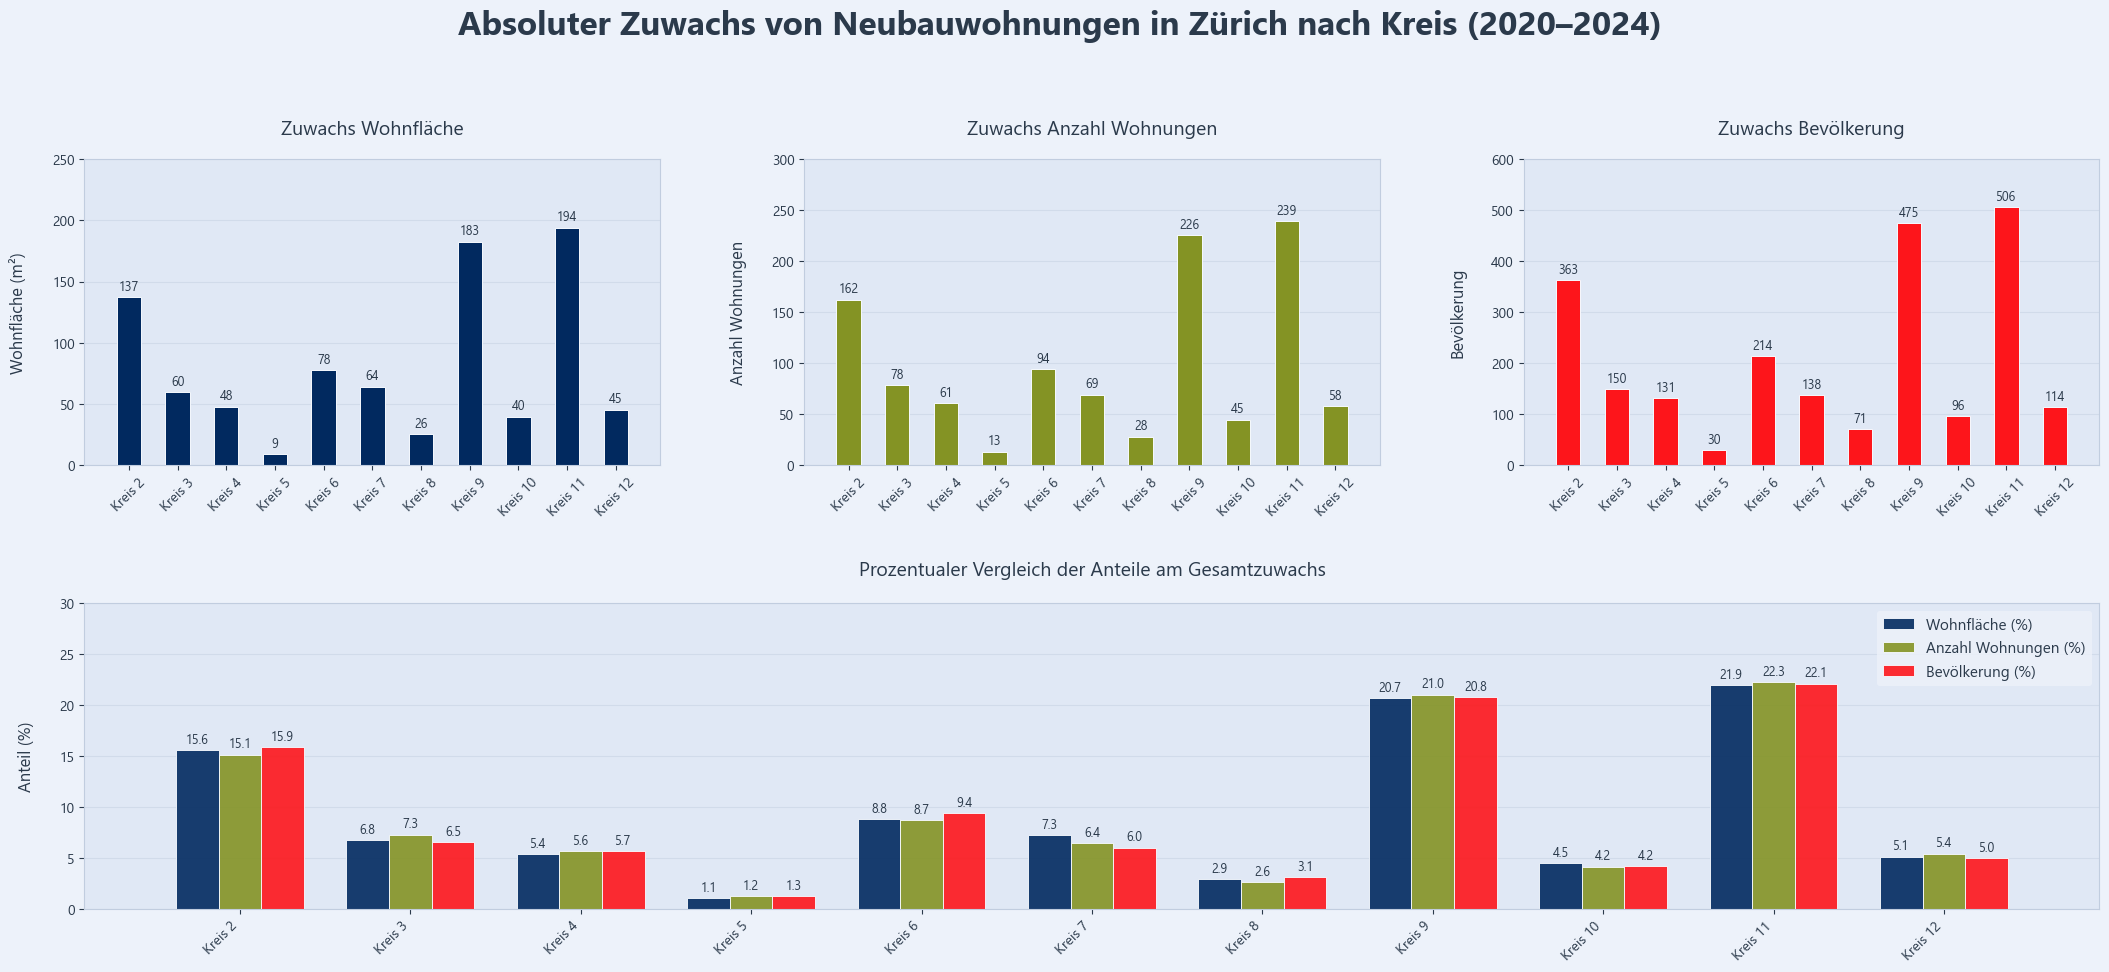

In [163]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# ============================================================
# Globaler Stil – Blue Harmony + professionelle Schrift
# ============================================================
plt.rcParams.update({
    "font.family": "Segoe UI",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 11,
    "text.color": "#2B3A4B",
    "axes.labelcolor": "#2B3A4B",
    "axes.titlecolor": "#2B3A4B",
    "xtick.color": "#2B3A4B",
    "ytick.color": "#2B3A4B",
    "legend.edgecolor": "none",
})

figure_bg = "#EDF2FA"
axes_bg   = "#E0E8F5"

color_living = "#01295F"
color_dwell  = "#849324"
color_pop    = "#FD151B"

edge_color   = "#F7FAFF"
grid_color   = "#B7C4D8"

# ============================================================
# Datenvorbereitung
# ============================================================
filtered = joined_df[joined_df["five_year_period"] == "2020–2024"]

df_3 = filtered[
    ["district_name", "living_area", "num_dwellings",
     "population_total", "five_year_period"]
].copy()

df_3["district_nr"] = df_3["district_name"].str.extract(r"Kreis (\d+)").astype(int)
df_3 = df_3.sort_values("district_nr")

x = df_3["district_name"]

living_abs = df_3["living_area"] / 1000
dwellings_abs = df_3["num_dwellings"] / 10
pop_abs = df_3["population_total"] / 10

# ============================================================
# Figure Setup
# ============================================================
fig1 = plt.figure(figsize=(26, 10))
fig1.patch.set_facecolor(figure_bg)

fig1.suptitle(
    "Absoluter Zuwachs von Neubauwohnungen in Zürich nach Kreis (2020–2024)",
    fontsize=24,
    fontweight="bold",
    y=1.01
)

gs = gridspec.GridSpec(2, 3, figure=fig1)

ax_abs4 = fig1.add_subplot(gs[1, :])
ax_abs1 = fig1.add_subplot(gs[0, 0], sharex=ax_abs4)
ax_abs2 = fig1.add_subplot(gs[0, 1], sharex=ax_abs4)
ax_abs3 = fig1.add_subplot(gs[0, 2], sharex=ax_abs4)

# ============================================================
# Helper: Achsenformat
# ============================================================
def format_axis(ax):
    ax.set_facecolor(axes_bg)
    ax.grid(axis="y", alpha=0.35, color=grid_color, linewidth=0.8)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_color("#C1CDDf")
        spine.set_linewidth(0.8)

# ============================================================
# Obere Plots: Absolute Werte + X-Labels mit Rotation 45°
# ============================================================
bar_width_top = 0.5

bars1 = ax_abs1.bar(
    x,
    living_abs,
    bar_width_top,
    color=color_living,
    edgecolor=edge_color,
    linewidth=0.7,
)
ax_abs1.set_title("Zuwachs Wohnfläche", pad=18)
ax_abs1.set_ylabel("Wohnfläche (m²)", labelpad=18)
ax_abs1.bar_label(bars1, padding=3, fmt="%.0f", fontsize=9)
ax_abs1.tick_params(axis="x", rotation=45)
format_axis(ax_abs1)
ax_abs1.set_ylim(0, 250)

bars2 = ax_abs2.bar(
    x,
    dwellings_abs,
    bar_width_top,
    color=color_dwell,
    edgecolor=edge_color,
    linewidth=0.7
)
ax_abs2.set_title("Zuwachs Anzahl Wohnungen", pad=18)
ax_abs2.set_ylabel("Anzahl Wohnungen", labelpad=18)
ax_abs2.bar_label(bars2, padding=3, fmt="%.0f", fontsize=9)
ax_abs2.tick_params(axis="x", rotation=45)
format_axis(ax_abs2)
ax_abs2.set_ylim(0, 300)

bars3 = ax_abs3.bar(
    x,
    pop_abs,
    bar_width_top,
    color=color_pop,
    edgecolor=edge_color,
    linewidth=0.7,
)
ax_abs3.set_title("Zuwachs Bevölkerung", pad=18)
ax_abs3.set_ylabel("Bevölkerung", labelpad=18)
ax_abs3.bar_label(bars3, padding=3, fmt="%.0f", fontsize=9)
ax_abs3.tick_params(axis="x", rotation=45)
format_axis(ax_abs3)
ax_abs3.set_ylim(0, 600)

# ============================================================
# Unterer Plot: Prozentwerte + Labels auch rotiert
# ============================================================
y1 = living_abs / living_abs.sum() * 100
y2 = dwellings_abs / dwellings_abs.sum() * 100
y3 = pop_abs / pop_abs.sum() * 100

x_pos = np.arange(len(x))
bar_width_bottom = 0.25

bars_y1 = ax_abs4.bar(
    x_pos - bar_width_bottom,
    y1,
    bar_width_bottom,
    color=color_living,
    alpha=0.9,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Wohnfläche (%)",
)

bars_y2 = ax_abs4.bar(
    x_pos,
    y2,
    bar_width_bottom,
    color=color_dwell,
    alpha=0.9,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Anzahl Wohnungen (%)",
)

bars_y3 = ax_abs4.bar(
    x_pos + bar_width_bottom,
    y3,
    bar_width_bottom,
    color=color_pop,
    alpha=0.9,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Bevölkerung (%)",
)

ax_abs4.set_title("Prozentualer Vergleich der Anteile am Gesamtzuwachs", pad=20)
ax_abs4.set_ylabel("Anteil (%)", labelpad=18)
ax_abs4.set_xticks(x_pos)
ax_abs4.set_xticklabels(x, ha="right", rotation=45)

legend = ax_abs4.legend(loc="upper right", frameon=True)
legend.get_frame().set_facecolor("#EDF2FA")
legend.get_frame().set_edgecolor("none")

ax_abs4.bar_label(bars_y1, padding=3, fmt="%.1f", fontsize=9)
ax_abs4.bar_label(bars_y2, padding=3, fmt="%.1f", fontsize=9)
ax_abs4.bar_label(bars_y3, padding=3, fmt="%.1f", fontsize=9)

format_axis(ax_abs4)
ax_abs4.set_ylim(0, 30)

# ============================================================
# Layout
# ============================================================
plt.subplots_adjust(hspace=0.45, wspace=0.25, top=0.86)

plt.show()
